In [2]:
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import sys
import glob
import itertools
import xarray as xr
import numpy as np
import pandas as pd
from rasterio import features, transform
import geopandas as gpd
from shapely.geometry import shape as shapelyshape

import pickle
import warnings
warnings.simplefilter("ignore")

In [3]:
GeofabricWB = pd.read_csv('./SH_Network_AHGFWaterbodyAttributeTable.csv')
WBAttrs = pd.read_csv('./DEAWaterbodiesAttributeTable.csv')

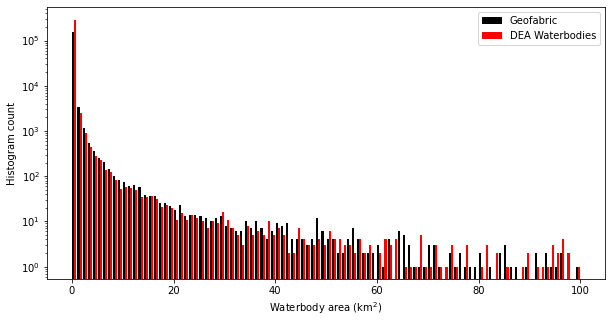

In [56]:
plt.figure(figsize=[10,5])
plt.hist([GeofabricWB['AlbersArea'] / 1000000, WBAttrs['area']/ 1000000], bins=100, range=(0, 100), 
         color = ['k', 'r'], log=True, label=['Geofabric', 'DEA Waterbodies']);
plt.legend(loc='upper right');
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel('Waterbody area (km$^2$)');
plt.ylabel('Histogram count');

In [5]:
plt.figure(figsize=[10,5])
plt.hist(GeofabricWB['AlbersArea']/ 1000000, bins=100, range=(0, 100), 
         color = 'r', log=True, label='Geofabric', alpha=0.4);
plt.hist(WBAttrs['area']/ 1000000, bins=100, range=(0, 100), 
         color = 'b', log=True, label='DEA Waterbodies', alpha=0.4);
plt.legend(loc='upper right');
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel('Waterbody area (km$^2$)');
plt.ylabel('Histogram count');
plt.title('Distribution of all waterbody areas', fontsize=16)
plt.savefig('WaterbodySizeHistogram.jpg')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
plt.figure(figsize=[10,5])
plt.hist(GeofabricWB['AlbersArea']/ 1000000, bins=80, range=(0, 0.1), 
         color = 'r', log=True, label='Geofabric', alpha=0.4);
plt.hist(WBAttrs['area']/ 1000000, bins=80, range=(0, 0.1), 
         color = 'b', log=True, label='DEA Waterbodies', alpha=0.4);
plt.legend(loc='upper right');
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel('Waterbody area (km$^2$)');
plt.ylabel('Histogram count');
plt.title('Distribution of waterbody areas for waterbodies smaller than 0.1km$^2$', fontsize=16)
plt.savefig('WaterbodySizeHistogramSmall.jpg')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Time first observed analysis

In [33]:
FirstObs = pd.read_csv('PaperData/AusWaterBodiesFINALTimeFirst50pcState.csv')

In [34]:
FirstObs['Time_First'] = pd.to_datetime(FirstObs['Time_First'], format="%Y-%m-%d", errors='coerce')

In [43]:
FirstObs.sort_values('Time_First')[-150:-100]

,area,perimeter,UID,Time_First,STATE,Shape_Leng,Shape_Area
192654,2.612500e+05,2851.589111,r63n18nx2,2016-07-14,NSW,2850.0,261250.0
192667,3.725000e+05,3446.771166,r63n9wc2d,2016-07-14,NSW,3450.0,372500.0
130786,1.062500e+04,553.693009,r28dwsmd1,2016-07-15,TAS,550.0,10625.0
130626,1.500000e+05,1951.916165,r28c5q8y9,2016-07-23,TAS,1950.0,150000.0
231686,1.937506e+04,750.547609,r7f8d21gs,2016-07-29,QLD,750.0,19375.0
129084,2.100000e+05,3560.857187,r22x5ey7j,2016-07-31,TAS,3550.0,210000.0
129175,6.375004e+04,1546.665564,r22zg4kfh,2016-07-31,TAS,1550.0,63750.0
129085,1.875003e+04,700.282958,r22x5sxw5,2016-07-31,TAS,700.0,18750.0
130669,2.631250e+05,3972.271968,r28crvk7g,2016-07-31,TAS,3950.0,263125.0
243651,3.562484e+04,1050.892469,rh7f7p1r0,2016-08-01,QLD,1050.0,35625.0


## Fitzroy River waterbody growth

In [2]:
# Read in shapefile
FRWB = gpd.read_file('PaperData/FitzroyRiverQLDWB.shp')

In [3]:
# Now sort out original DF so the dates are in order
FRWB.sort_values('Time First', inplace=True, ignore_index=True)
# The first Time First value is a NaN, so let's just drop it
FRWB = FRWB[1:]

# Create a copy without the datetime format
FRWBDT = FRWB.copy()

# Convert Time First to a datetime
FRWBDT['Time First'] = pd.to_datetime(FRWBDT['Time First'], format="%Y-%m-%d", errors='coerce')

# Set the DF index to Time First, then sort earliest to latest
# FRWBindex = FRWBDT.resample('3M', on = 'Time First').sum()

# Convert the area from m2 to km2
FRWBDT['area'] = FRWBDT['area'] / 1000000

# Make a column for the cumulative growth in area
FRWBDT['Cumarea'] = FRWBDT['area'].cumsum()

In [4]:
FRWBDT

,area,perimeter,UID,FID,Time First,geometry,Cumarea
1,0.009375,549.624488,rk16b7r0s,288028,1986-08-19,"POLYGON ((1637425.000 -2469625.000, 1637450.00...",0.009375
2,0.008750,549.582328,r7bznfp8g,225929,1986-08-19,"POLYGON ((1585950.000 -2538225.000, 1585975.00...",0.018125
3,0.031875,1854.038178,r7fp08cdf,232313,1986-08-19,"POLYGON ((1734575.000 -2557950.000, 1734600.00...",0.050000
4,0.007500,400.013038,rk15zps48,288003,1986-08-19,"POLYGON ((1634150.000 -2446775.000, 1634225.00...",0.057500
5,0.022500,801.546907,rk15yzjn3,287988,1986-08-19,"POLYGON ((1633225.000 -2446850.000, 1633275.00...",0.080000
...,...,...,...,...,...,...,...
11059,0.050000,2240.916098,rk16t3scc,288058,2016-02-20,"POLYGON ((1658675.000 -2478550.000, 1658675.00...",813.125636
11060,0.003750,348.016898,rk16mryb7,288047,2016-02-28,"POLYGON ((1658800.000 -2479425.000, 1658825.00...",813.129386
11061,0.055000,1396.238697,r7cgkcty0,227236,2016-04-08,"POLYGON ((1709250.000 -2628550.000, 1709250.00...",813.184386
11062,0.019375,750.547609,r7f8d21gs,231686,2016-07-29,"POLYGON ((1795775.000 -2695975.000, 1795775.00...",813.203761


### Make a horizontal bar chart of time vs cumulative area

In [5]:
# Keep only the columns we need for the plot
FRWBDTdropped = FRWBDT[['area', 'Time First', 'Cumarea']]

In [6]:
# Make the cumulative area the index
FRWBDTdroppedPlot = FRWBDTdropped.set_index('Cumarea'); 

# Now re-index using the existing index, plus evenly spaced cumareas from 0 to max(FRWBDTdropped.Cumarea)
FRWBDTdroppedPlot = FRWBDTdroppedPlot.reindex(FRWBDTdroppedPlot.index.union(pd.Index(np.linspace(0, max(FRWBDTdropped.Cumarea), 1000))))

# Copy the values onto that evenly spaced new index
FRWBDTdroppedPlot = FRWBDTdroppedPlot.fillna(method='ffill')

# Now just keep the new evenly spaced index values
FRWBDTdroppedPlot = FRWBDTdroppedPlot.loc[FRWBDTdroppedPlot.index.intersection(np.linspace(0, max(FRWBDTdropped.Cumarea), 1000))]

# Drop the first row - it's NaN
FRWBDTdroppedPlot = FRWBDTdroppedPlot[1:]

In [7]:
FRWBDTdroppedPlot

,area,Time First
1.628043,0.004375,1986-08-19
2.442065,0.003750,1986-08-19
3.256086,0.003750,1986-08-19
4.070108,0.008125,1986-08-19
4.884129,0.008125,1986-08-19
...,...,...
809.951425,0.017500,2014-07-24
810.765447,0.026875,2014-09-02
811.579468,0.009375,2014-12-15
812.393490,0.011250,2015-02-09


In [31]:
test = zip(cmaplist, FRWBDTdroppedPlot['Time First'].dt.strftime('%Y-%m-%d'))
test = list(test)

In [32]:
test.

[((0.050383, 0.029803, 0.527975, 1.0), '1986-08-19'),
 ((0.050383, 0.029803, 0.527975, 1.0), '1986-08-19'),
 ((0.050383, 0.029803, 0.527975, 1.0), '1986-08-19'),
 ((0.050383, 0.029803, 0.527975, 1.0), '1986-08-19'),
 ((0.063536, 0.028426, 0.533124, 1.0), '1986-08-19'),
 ((0.063536, 0.028426, 0.533124, 1.0), '1986-08-19'),
 ((0.063536, 0.028426, 0.533124, 1.0), '1986-08-19'),
 ((0.063536, 0.028426, 0.533124, 1.0), '1986-08-19'),
 ((0.075353, 0.027206, 0.538007, 1.0), '1986-08-19'),
 ((0.075353, 0.027206, 0.538007, 1.0), '1986-08-19'),
 ((0.075353, 0.027206, 0.538007, 1.0), '1986-08-19'),
 ((0.075353, 0.027206, 0.538007, 1.0), '1986-08-19'),
 ((0.086222, 0.026125, 0.542658, 1.0), '1986-08-19'),
 ((0.086222, 0.026125, 0.542658, 1.0), '1986-08-19'),
 ((0.086222, 0.026125, 0.542658, 1.0), '1986-08-19'),
 ((0.086222, 0.026125, 0.542658, 1.0), '1986-08-19'),
 ((0.096379, 0.025165, 0.547103, 1.0), '1986-08-19'),
 ((0.096379, 0.025165, 0.547103, 1.0), '1986-08-19'),
 ((0.096379, 0.025165, 0.547

### Make a cumulative area plot

In [8]:
# Set up a custom colorbar
from matplotlib import cm
cmap = plt.cm.plasma  # define the colormap
# extract all colors from the plasma map
cmaplist = [cmap(i) for i in np.linspace(0, 1, len(FRWBDTdroppedPlot.index))]

In [9]:
fig, ax = plt.subplots(figsize=([10, 6]))
plt.barh(FRWBDTdroppedPlot.index, width=(FRWBDTdroppedPlot['Time First'].max() - FRWBDTdroppedPlot['Time First']), 
         left=FRWBDTdroppedPlot['Time First'], height=1, color=cmaplist)
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel('Time waterbody first observed at $\geq$ 50% wet surface area', fontsize=14);
plt.ylabel('Cumulative area (km$^2$)', fontsize=14);
plt.xlim([pd.to_datetime('1990-01-01', format="%Y-%m-%d"), pd.to_datetime('2018-01-01', format="%Y-%m-%d")]);
plt.title('Cumulative waterbody area in Fitzroy River catchment, QLD', fontsize=16);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
FRWBDTStr = FRWBDT.copy()
FRWBDTStr['Time First'] = str(FRWBDTStr['Time First'])
# FRWBDTStr.to_file('FitzroyRiver3MonthBinCum.shp')

In [14]:
FRWBDTStr['Time First']

1        1       1986-08-19\n2       1986-08-19\n3     ...
2        1       1986-08-19\n2       1986-08-19\n3     ...
3        1       1986-08-19\n2       1986-08-19\n3     ...
4        1       1986-08-19\n2       1986-08-19\n3     ...
5        1       1986-08-19\n2       1986-08-19\n3     ...
                               ...                        
11059    1       1986-08-19\n2       1986-08-19\n3     ...
11060    1       1986-08-19\n2       1986-08-19\n3     ...
11061    1       1986-08-19\n2       1986-08-19\n3     ...
11062    1       1986-08-19\n2       1986-08-19\n3     ...
11063    1       1986-08-19\n2       1986-08-19\n3     ...
Name: Time First, Length: 11063, dtype: object